In [1]:
#Loading necessary libraries for the project at hand
import warnings
import pandas as pd
import gradio as gr 
import numpy as np
import matplotlib.pyplot as plt
import shap
from lightgbm import LGBMRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
import pylab
import scipy.stats as stats
import seaborn as sns 
from pandasql import sqldf #SQL for data wrangling
from xgboost import (XGBClassifier, plot_importance)
from time import time
from sklearn import metrics
from sklearn.metrics import mean_squared_error as MSE

%matplotlib inline 
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [2]:
#Read dataset
df_LOS = pd.read_csv("/Users/.../LengthOfStay_CHF.csv",encoding='windows-1252')
df_LOS.head()

,eid,admitdate,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,bloodureanitro,creatinine,bmi,pulse,respiration,primarydiagnosisicd10,secondarydiagnosisicd10,dischargeddate,facid,lengthofstay
0,1,8/29/2021,0,F,0,0,0,0,0,0,...,12.0,1.390722,30.432418,96,6.5,I26,NaN,9/1/2021,B,3
1,2,5/26/2021,5+,F,0,0,0,0,0,0,...,8.0,0.943164,28.460516,61,6.5,I50.22,NaN,6/2/2021,A,7
2,3,9/22/2021,1,F,0,0,0,0,0,0,...,12.0,1.065750,28.843812,64,6.5,N18,N18,9/25/2021,B,3
3,4,8/9/2021,0,F,0,0,0,0,0,0,...,12.0,0.906862,27.959007,76,6.5,I50.22,N19,8/10/2021,A,1
4,5,12/20/2021,0,F,0,0,0,1,0,1,...,11.5,1.242854,30.258927,67,5.6,N18,N20,12/24/2021,E,4


In [3]:
#Data structure
df_LOS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99476 entries, 0 to 99475
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   eid                         99476 non-null  int64  
 1   admitdate                   99476 non-null  object 
 2   rcount                      99476 non-null  object 
 3   gender                      99476 non-null  object 
 4   dialysisrenalendstage       99476 non-null  int64  
 5   asthma                      99476 non-null  int64  
 6   irondef                     99476 non-null  int64  
 7   pneum                       99476 non-null  int64  
 8   substancedependence         99476 non-null  int64  
 9   psychologicaldisordermajor  99476 non-null  int64  
 10  depress                     99476 non-null  int64  
 11  psychother                  99476 non-null  int64  
 12  fibrosisandother            99476 non-null  int64  
 13  malnutrition                994

In [4]:
#Select Specific Data Elements for CHF - Congestive Heart Failure
a="""select * from df_LOS x 
where (x.primarydiagnosisicd10 in ('I50.20','I50.21','I50.22','I50.23')
or    x.secondarydiagnosisicd10 in ('I50.20','I50.21','I50.22','I50.23')
or substr(x.primarydiagnosisicd10,1,3) = 'I50'
or substr(x.secondarydiagnosisicd10,1,3) = 'I50');"""
pysqldf = lambda a: sqldf(a, globals())
CHF_data = pysqldf(a)

In [5]:
#Drop primarydiagnosisicd10 & secondarydiagnosisicd10
CHF_data = CHF_data.drop('primarydiagnosisicd10', axis=1)
CHF_data = CHF_data.drop('secondarydiagnosisicd10', axis=1)

In [6]:
#Column info
for col in CHF_data.columns: 
    display(CHF_data[col].value_counts())

2        1
66203    1
66159    1
66160    1
66161    1
        ..
32824    1
32827    1
32828    1
32829    1
99475    1
Name: eid, Length: 49757, dtype: int64

10/3/2021     175
11/24/2021    170
2/19/2021     165
5/7/2021      165
8/14/2021     164
             ... 
3/20/2021     107
12/1/2021     104
4/8/2021      101
7/19/2021      95
1/11/2021      91
Name: admitdate, Length: 366, dtype: int64

0     27389
1      7521
2      4932
3      3999
4      3443
5+     2473
Name: rcount, dtype: int64

F    28726
M    21031
Name: gender, dtype: int64

0    47961
1     1796
Name: dialysisrenalendstage, dtype: int64

0    47986
1     1771
Name: asthma, dtype: int64

0    44976
1     4781
Name: irondef, dtype: int64

0    47762
1     1995
Name: pneum, dtype: int64

0    46565
1     3192
Name: substancedependence, dtype: int64

0    37874
1    11883
Name: psychologicaldisordermajor, dtype: int64

0    47220
1     2537
Name: depress, dtype: int64

0    47321
1     2436
Name: psychother, dtype: int64

0    49519
1      238
Name: fibrosisandother, dtype: int64

0    47367
1     2390
Name: malnutrition, dtype: int64

0    45776
1     3981
Name: hemo, dtype: int64

11.900000    10033
12.000000     2436
11.800000      792
11.600000      772
12.100000      741
             ...  
8.975000         1
11.233333        1
23.600000        1
8.325000         1
10.875000        1
Name: hematocrit, Length: 347, dtype: int64

9.400000      9775
9.300000      2094
6.900000       479
7.400000       446
7.800000       438
              ... 
13.825000        1
129.800000       1
5.933333         1
19.350000        1
8.660000         1
Name: neutrophils, Length: 630, dtype: int64

137.272061    2
137.328215    2
134.454042    2
139.406150    2
140.297810    2
             ..
144.675721    1
140.379434    1
136.429368    1
137.258284    1
135.980516    1
Name: sodium, Length: 49748, dtype: int64

148.470465    2
129.720211    2
94.078507     1
129.807592    1
117.823688    1
             ..
155.101554    1
152.360752    1
144.213998    1
148.774400    1
111.750731    1
Name: glucose, Length: 49755, dtype: int64

12.000000    22598
9.000000      2064
10.000000     1913
11.000000     1889
13.000000     1701
             ...  
23.666667        1
84.000000        1
16.333333        1
37.400000        1
19.250000        1
Name: bloodureanitro, Length: 243, dtype: int64

0.927038    2
0.943164    1
1.181331    1
1.557857    1
1.367350    1
           ..
1.036887    1
1.274836    1
1.260038    1
1.362344    1
1.035400    1
Name: creatinine, Length: 49756, dtype: int64

28.460516    1
29.747109    1
30.025996    1
29.725365    1
25.714128    1
            ..
30.858499    1
32.191053    1
33.103659    1
27.805047    1
29.193462    1
Name: bmi, Length: 49757, dtype: int64

71     1748
72     1689
73     1683
74     1657
70     1656
       ... 
21        1
23        1
116       1
117       1
28        1
Name: pulse, Length: 92, dtype: int64

6.500000    32162
6.200000      769
6.700000      748
6.400000      748
6.300000      733
            ...  
5.575000        1
2.800000        1
3.400000        1
4.866667        1
3.300000        1
Name: respiration, Length: 158, dtype: int64

8/16/2021     166
2/19/2021     166
9/13/2021     165
10/18/2021    162
4/7/2021      162
             ... 
1/9/2022       14
1/10/2022       5
1/12/2022       2
1/13/2022       1
1/11/2022       1
Name: dischargeddate, Length: 377, dtype: int64

E    15305
B    15016
A    14876
C     2300
D     2260
Name: facid, dtype: int64

1     9001
3     7985
4     7305
2     6433
5     6114
6     5094
7     3606
8     2297
9     1076
10     502
11     212
12      68
13      41
14      16
15       5
16       2
Name: lengthofstay, dtype: int64

In [7]:
#Data Cleaning
#Type conversions 
datetime_cols = ["admitdate", "dischargeddate"]
cat_cols = ["gender", "rcount", "facid"]
bin_cols = ["dialysisrenalendstage", 
            "asthma", 
            "irondef", 
            "pneum", 
            "substancedependence", 
            "psychologicaldisordermajor",
            "depress",
            "psychother",
            "fibrosisandother",
            "malnutrition",
            "hemo"]
num_cols = ["hematocrit",
            "neutrophils",
            "sodium",
            "glucose",
            "bloodureanitro",
            "creatinine",
            "bmi",
            "respiration"]

for date_col, cat_col in zip(datetime_cols, cat_cols): 
    CHF_data[date_col] = pd.to_datetime(CHF_data[date_col], format="%m/%d/%Y")
    CHF_data[cat_col] = CHF_data[cat_col].astype("category")
CHF_data.head()

,eid,admitdate,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,dischargeddate,facid,lengthofstay
0,2,2021-05-26,5+,F,0,0,0,0,0,0,...,136.731692,94.078507,8.0,0.943164,28.460516,61,6.5,2021-06-02,A,7
1,4,2021-08-09,0,F,0,0,0,0,0,0,...,138.994023,163.377028,12.0,0.906862,27.959007,76,6.5,2021-08-10,A,1
2,6,2021-11-27,3,M,0,0,0,0,0,0,...,136.593064,120.265259,11.0,0.884663,27.875940,83,6.1,2021-12-03,B,6
3,9,2021-07-05,0,F,0,0,0,0,1,0,...,135.980274,100.283199,12.0,1.178786,28.802682,69,6.5,2021-07-08,E,3
4,11,2021-05-11,0,F,0,0,0,0,0,0,...,140.060831,121.899082,7.0,1.254258,30.325155,73,6.5,2021-05-12,B,1


In [8]:
#Data Summary
CHF_data.describe()

,eid,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,depress,psychother,fibrosisandother,...,hematocrit,neutrophils,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,lengthofstay
count,49757.000000,49757.000000,49757.000000,49757.000000,49757.000000,49757.000000,49757.000000,49757.000000,49757.000000,49757.000000,...,49757.000000,49757.000000,49757.000000,49757.000000,49757.000000,49757.000000,49757.000000,49757.000000,49757.000000,49757.000000
mean,49589.528006,0.036095,0.035593,0.096087,0.040095,0.064152,0.238821,0.050988,0.048958,0.004783,...,11.976126,10.190413,137.896552,141.912293,14.057964,1.100443,29.807950,73.464477,6.493629,3.989589
std,28708.386339,0.186529,0.185275,0.294713,0.196184,0.245026,0.426367,0.219975,0.215782,0.068996,...,2.024257,5.465452,2.995534,29.917560,12.976672,0.200266,2.007656,11.643598,0.568874,2.354977
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.400000,0.100000,126.243559,-1.005927,2.000000,0.219770,22.037695,21.000000,0.200000,1.000000
25%,24685.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.900000,7.700000,135.878681,121.627023,11.000000,0.965434,28.452670,66.000000,6.500000,2.000000
50%,49471.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,11.900000,9.400000,137.889262,142.025393,12.000000,1.100256,29.807538,73.000000,6.500000,4.000000
75%,74427.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,12.900000,11.400000,139.920184,162.009719,14.000000,1.235620,31.166238,81.000000,6.500000,6.000000
max,99475.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,24.100000,245.900000,151.387283,271.444277,682.500000,1.878477,37.865567,118.000000,10.000000,16.000000


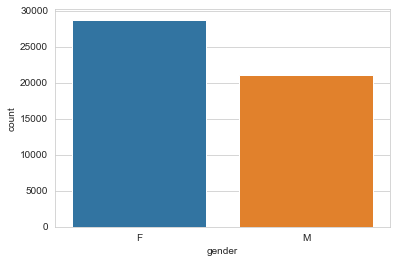

In [9]:
#Graph Distribution - gender
sns.countplot(CHF_data['gender'])
plt.show()
#Model fairness - Responsible AI to be revisited later

((array([-4.19027955, -3.98447955, -3.87227718, ...,  3.87227718,
          3.98447955,  4.19027955]),
  array([22.03769476, 22.35666744, 22.37803634, ..., 37.68183631,
         37.79983594, 37.86556724])),
 (2.0077705150636915, 29.8079497033953, 0.9999839517358663))

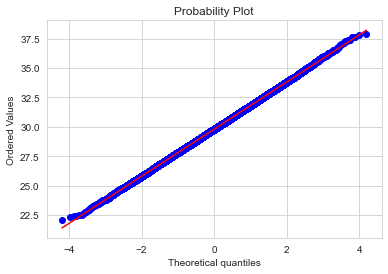

In [10]:
#Test for normality
#dialysisrenalendstage
#asthma
#irondef
#pneum
#substancedependence
#psychologicaldisordermajor
#depress
#psychother
#fibrosisandother
#malnutrition
#hemo
#hematocrit
#neutrophils
#sodium
#glucose
#bloodureanitro
#creatinine
#bmi
#pulse
#respiration
#secondarydiagnosisnonicd9
#discharged
#facid
#lengthofstay
stats.probplot(CHF_data['bmi'], dist="norm",plot=pylab)

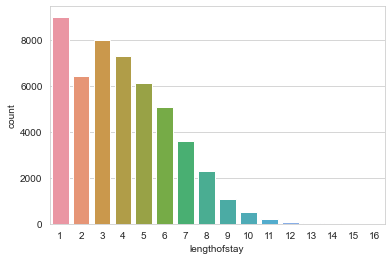

In [11]:
#LOS Distribution
sns.countplot(CHF_data['lengthofstay'])
plt.show()

In [12]:
#Feature Engineering
#Number_of_issues transform function
def calculate_number_of_issues(CHF_data, bin_cols):
    CHF_data["numberofissues"] = CHF_data[bin_cols].sum(axis=1)
    return CHF_data

CHF_data = calculate_number_of_issues(CHF_data, bin_cols)

In [13]:
#Modeling
labels, features_LOS = CHF_data[["lengthofstay"]], CHF_data.drop(["lengthofstay", "dischargeddate", "admitdate", "eid"], axis=1)
labels.value_counts()

lengthofstay
1               9001
3               7985
4               7305
2               6433
5               6114
6               5094
7               3606
8               2297
9               1076
10               502
11               212
12                68
13                41
14                16
15                 5
16                 2
dtype: int64

In [14]:
features_LOS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49757 entries, 0 to 49756
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   rcount                      49757 non-null  category
 1   gender                      49757 non-null  category
 2   dialysisrenalendstage       49757 non-null  int64   
 3   asthma                      49757 non-null  int64   
 4   irondef                     49757 non-null  int64   
 5   pneum                       49757 non-null  int64   
 6   substancedependence         49757 non-null  int64   
 7   psychologicaldisordermajor  49757 non-null  int64   
 8   depress                     49757 non-null  int64   
 9   psychother                  49757 non-null  int64   
 10  fibrosisandother            49757 non-null  int64   
 11  malnutrition                49757 non-null  int64   
 12  hemo                        49757 non-null  int64   
 13  hematocrit      

In [15]:
#Set a seed and a test size for splitting the dataset 
seed = 8 # for reproducibility
test_size = 0.5
x_train, x_test, y_train, y_test = train_test_split(features_LOS, labels,test_size = test_size,random_state = seed)

In [16]:
#Training model
regressor = make_pipeline(
    ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(), cat_cols),
    ], remainder="passthrough"),
    LGBMRegressor(n_jobs=-1)
)
regressor.fit(x_train, y_train)
preds_test = np.round(regressor.predict(x_test), 0)
print(r2_score(preds_test, y_test))
print(metrics.mean_squared_log_error(preds_test, y_test))

0.9571696074653455
0.010831862526709903


In [17]:
#Test model
regressor = make_pipeline(
    ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(), cat_cols),
    ], remainder="passthrough"),
    LGBMRegressor(n_jobs=-1)
)
regressor.fit(x_test, y_test)
preds_train = np.round(regressor.predict(x_train), 0)
print(r2_score(preds_train, y_train))
print(metrics.mean_squared_log_error(preds_train, y_train))

0.955945034297168
0.010914702435254808


In [18]:
explainer = shap.Explainer(regressor[1], feature_names=regressor[:-1].get_feature_names_out())

observations = regressor[0].transform(x_test)
shap_values = explainer(observations)
shap_values.shape

(24879, 34)

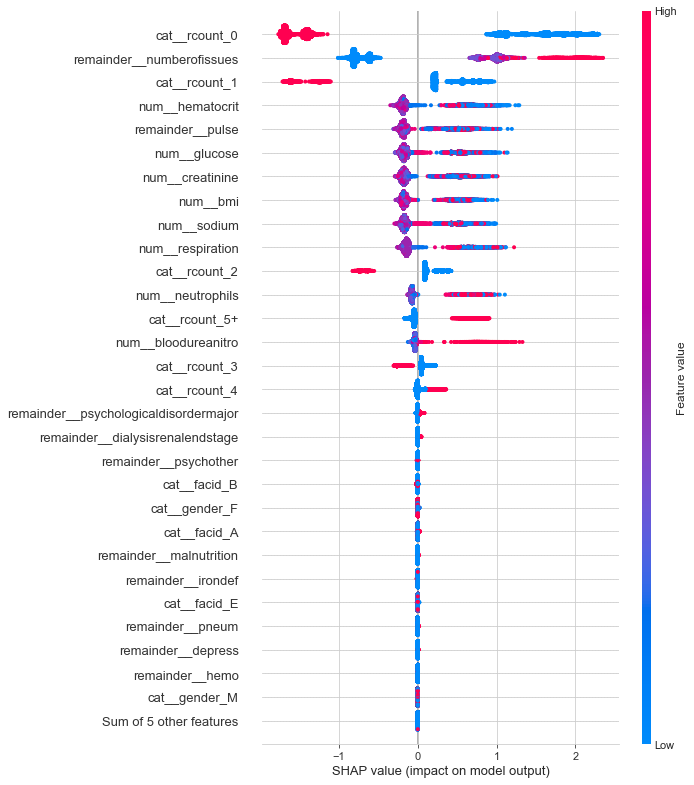

<Figure size 432x288 with 0 Axes>

In [19]:
shap.plots.beeswarm(shap_values,  max_display=30)
plt.savefig('beeswarm_lengthofstay.jpg')

In [20]:
#Convert and combine predictions to dataframes - train
prediction_train=pd.DataFrame.from_dict(preds_train)
new_one_train=pd.concat([x_train, y_train], axis=1,ignore_index=True)
prediction_train.rename(columns = {0:25}, inplace = True)
train_final=pd.concat([new_one_train, prediction_train.set_index(new_one_train.index)], axis=1)

In [21]:
#Convert and combine predictions to dataframes - test
prediction_test=pd.DataFrame.from_dict(preds_test)
new_one_test=pd.concat([x_test, y_test], axis=1,ignore_index=True)
prediction_test.rename(columns = {0:25}, inplace = True)
test_final=pd.concat([new_one_test, prediction_test.set_index(new_one_test.index)], axis=1)

In [22]:
#Combine dataframes
Consolidate=pd.concat([train_final, test_final])

In [23]:
#Include column names
Final_Results = Consolidate.rename(columns = {0: 'rcount',1: 'gender',2: 'dialysisrenalendstage',3: 'asthma',4: 'irondef',
5: 'pneum',6: 'substancedependence',7: 'psychologicaldisordermajor',8: 'depress',9: 'psychother',10: 'fibrosisandother',11: 'malnutrition',12: 'hemo',
13: 'hematocrit',14: 'neutrophils',15: 'sodium',16: 'glucose',17: 'bloodureanitro',18: 'creatinine',
19: 'bmi',20: 'pulse',21: 'respiration',22: 'facid',
23: 'numberofissues',24: 'actual_LOS',25: 'predicted_LOS'}, inplace = False)

In [24]:
print(Final_Results)

      rcount gender  dialysisrenalendstage  asthma  irondef  pneum  \
17694      1      M                      0       0        0      0   
27536      0      F                      0       0        0      0   
43187      0      F                      0       0        0      0   
2528       0      M                      0       0        0      1   
4412       4      F                      0       0        0      0   
...      ...    ...                    ...     ...      ...    ...   
9375       0      F                      0       0        1      0   
41707      3      M                      0       0        0      0   
11828      0      F                      0       0        0      0   
39535      0      F                      0       1        1      0   
45594      0      M                      0       0        0      0   

       substancedependence  psychologicaldisordermajor  depress  psychother  \
17694                    0                           0        0           0   
2

In [25]:
#Holdout
#Fairness Test

In [26]:
#Save model as a pickle file
model = regressor.fit(x_train, y_train)

In [27]:
#Holdout Testing
holdout_df=pd.read_csv("/Users/.../LengthOfStay_ProdCHF.csv",encoding='windows-1252')
holdout_df.head()

,eid,admitdate,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,primarydiagnosisicd10,secondarydiagnosisicd10,dischargeddate,facid
0,29000,4/26/2021,0,F,0,0,1,0,0,0,...,135.760839,26.0,1.125323,29.410090,84.046775,5.5,N18,NaN,4/30/2021,C
1,29001,1/17/2021,0,F,0,0,0,0,0,0,...,170.677225,16.0,1.221446,27.656177,85.141904,6.5,I50.22,NaN,1/18/2021,A
2,29002,2/11/2021,0,F,0,0,0,0,0,0,...,139.790366,12.0,0.937302,29.923813,44.658802,6.5,I50.22,I50.21,2/12/2021,B
3,29003,10/2/2021,0,M,1,0,0,0,0,0,...,113.881485,25.0,1.178341,26.072578,75.119608,6.5,E10,N18,10/5/2021,C
4,29004,7/10/2021,0,F,0,0,0,0,0,1,...,161.821043,7.0,0.758273,32.230980,70.926042,6.2,I50.22,N19,7/16/2021,E


In [28]:
#Select Specific Data Elements for CHF - Congestive Heart Failure
a="""select * from holdout_df x 
where (x.primarydiagnosisicd10 in ('I50.20','I50.21','I50.22','I50.23')
or    x.secondarydiagnosisicd10 in ('I50.20','I50.21','I50.22','I50.23')
or substr(x.primarydiagnosisicd10,1,3) = 'I50'
or substr(x.secondarydiagnosisicd10,1,3) = 'I50');"""
pysqldf = lambda a: sqldf(a, globals())
holdout_data = pysqldf(a)

In [29]:
#Drop primarydiagnosisicd10 & secondarydiagnosisicd10
holdout_data = holdout_data.drop('primarydiagnosisicd10', axis=1)
holdout_data = holdout_data.drop('secondarydiagnosisicd10', axis=1)

In [30]:
#Column info
for col in holdout_data.columns: 
    display(holdout_data[col].value_counts())

29001    1
29660    1
29682    1
29681    1
29680    1
        ..
29314    1
29312    1
29311    1
29310    1
29993    1
Name: eid, Length: 540, dtype: int64

1/7/2021     6
3/5/2021     6
3/27/2021    5
1/25/2021    5
6/15/2021    5
            ..
4/24/2021    1
2/20/2021    1
8/26/2021    1
2/23/2021    1
4/20/2021    1
Name: admitdate, Length: 277, dtype: int64

0     296
1      92
2      51
3      45
4      33
5+     23
Name: rcount, dtype: int64

F    302
M    238
Name: gender, dtype: int64

0    515
1     25
Name: dialysisrenalendstage, dtype: int64

0    529
1     11
Name: asthma, dtype: int64

0    494
1     46
Name: irondef, dtype: int64

0    526
1     14
Name: pneum, dtype: int64

0    492
1     48
Name: substancedependence, dtype: int64

0    426
1    114
Name: psychologicaldisordermajor, dtype: int64

0    511
1     29
Name: depress, dtype: int64

0    508
1     32
Name: psychother, dtype: int64

0    534
1      6
Name: fibrosisandother, dtype: int64

0    512
1     28
Name: malnutrition, dtype: int64

0    488
1     52
Name: hemo, dtype: int64

11.9    121
11.8     13
13.1     12
12.4     11
12.3     11
       ... 
7.7       1
19.6      1
16.9      1
7.4       1
14.2      1
Name: hematocrit, Length: 110, dtype: int64

9.4     115
8.2       8
8.1       8
10.3      7
6.6       7
       ... 
17.8      1
17.9      1
3.3       1
24.0      1
12.4      1
Name: neutrophils, Length: 164, dtype: int64

132.951615    1
134.694017    1
137.427848    1
138.687052    1
139.289615    1
             ..
139.975909    1
142.213215    1
132.423516    1
138.307295    1
137.712215    1
Name: sodium, Length: 540, dtype: int64

170.677225    1
97.226667     1
75.465770     1
149.899188    1
160.579334    1
             ..
90.061017     1
160.480684    1
159.538033    1
121.841039    1
137.316304    1
Name: glucose, Length: 540, dtype: int64

12.000000     230
13.000000      27
9.000000       27
11.000000      26
15.000000      20
8.000000       19
7.000000       17
10.000000      17
6.000000       14
14.000000      14
4.000000       13
18.000000      10
16.000000       9
5.000000        8
27.000000       8
17.000000       7
20.000000       7
21.000000       6
25.000000       6
24.000000       5
22.000000       5
14.500000       3
44.000000       2
29.000000       2
41.000000       2
28.000000       2
51.000000       2
23.000000       2
26.000000       2
36.000000       2
35.000000       2
74.000000       1
80.000000       1
32.000000       1
104.000000      1
50.000000       1
6.500000        1
10.250000       1
95.000000       1
47.000000       1
29.333333       1
60.000000       1
43.000000       1
24.500000       1
7.500000        1
31.000000       1
30.000000       1
58.000000       1
40.000000       1
37.000000       1
54.000000       1
11.500000       1
90.000000       1
4.250000        1
56.000000       1
Name: bloo

1.221446    1
1.129520    1
0.759000    1
1.460799    1
1.201518    1
           ..
1.376938    1
1.235499    1
1.229399    1
1.309240    1
1.378307    1
Name: creatinine, Length: 540, dtype: int64

27.656177    1
29.832995    1
27.138161    1
29.678027    1
26.914202    1
            ..
29.544070    1
29.056304    1
30.436478    1
30.595985    1
32.733933    1
Name: bmi, Length: 540, dtype: int64

85.141904    1
82.351299    1
65.105209    1
91.407730    1
80.533723    1
            ..
80.893224    1
73.508636    1
59.788234    1
69.610417    1
60.676708    1
Name: pulse, Length: 540, dtype: int64

6.500000    341
6.100000     13
7.100000     11
6.400000      9
6.900000      9
7.300000      9
5.900000      8
5.300000      8
7.500000      8
7.200000      8
5.800000      8
5.600000      7
5.200000      6
6.000000      6
7.000000      6
6.600000      6
5.700000      6
6.200000      6
7.400000      5
7.600000      4
5.500000      4
6.300000      4
4.800000      4
6.700000      4
4.900000      4
8.300000      3
5.000000      3
5.400000      3
6.800000      3
7.800000      3
5.100000      2
7.700000      2
8.000000      2
7.900000      2
8.400000      1
4.200000      1
3.100000      1
5.950000      1
4.700000      1
5.566667      1
5.550000      1
6.250000      1
6.675000      1
3.850000      1
5.250000      1
3.900000      1
4.600000      1
Name: respiration, dtype: int64

9/20/2021     7
1/30/2021     6
8/23/2021     5
3/25/2021     5
8/2/2021      5
             ..
7/29/2021     1
10/13/2021    1
1/3/2022      1
9/8/2021      1
4/21/2021     1
Name: dischargeddate, Length: 278, dtype: int64

B    171
A    164
E    164
C     23
D     18
Name: facid, dtype: int64

In [31]:
#Data Cleaning
#Type conversions 
datetime_cols = ["admitdate", "dischargeddate"]
cat_cols = ["gender", "rcount", "facid"]
bin_cols = ["dialysisrenalendstage", 
            "asthma", 
            "irondef", 
            "pneum", 
            "substancedependence", 
            "psychologicaldisordermajor",
            "depress",
            "psychother",
            "fibrosisandother",
            "malnutrition",
            "hemo"]
num_cols = ["hematocrit",
            "neutrophils",
            "sodium",
            "glucose",
            "bloodureanitro",
            "creatinine",
            "bmi",
            "respiration"]

for date_col, cat_col in zip(datetime_cols, cat_cols): 
    holdout_data[date_col] = pd.to_datetime(holdout_data[date_col], format="%m/%d/%Y")
    holdout_data[cat_col] = holdout_data[cat_col].astype("category")
holdout_data.head()

,eid,admitdate,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,neutrophils,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,dischargeddate,facid
0,29001,2021-01-17,0,F,0,0,0,0,0,0,...,7.2,132.951615,170.677225,16.0,1.221446,27.656177,85.141904,6.5,2021-01-18,A
1,29002,2021-02-11,0,F,0,0,0,0,0,0,...,9.4,135.126036,139.790366,12.0,0.937302,29.923813,44.658802,6.5,2021-02-12,B
2,29004,2021-07-10,0,F,0,0,0,0,0,1,...,11.1,134.282144,161.821043,7.0,0.758273,32.230980,70.926042,6.2,2021-07-16,E
3,29006,2021-01-05,0,F,0,0,0,0,0,0,...,13.9,134.874079,96.211528,12.0,1.144914,31.810625,83.744818,6.5,2021-01-06,A
4,29008,2021-01-28,1,M,1,0,1,0,0,0,...,8.2,133.270156,220.438195,15.0,1.343796,33.040237,77.011371,7.4,2021-02-06,B


In [32]:
#Feature Engineering
#Number_of_issues transform function
def calculate_number_of_issues(holdout_data, bin_cols):
    holdout_data["numberofissues"] = holdout_data[bin_cols].sum(axis=1)
    return holdout_data

holdout_data = calculate_number_of_issues(holdout_data, bin_cols)

In [33]:
#onehot encoding is an option that could be leveraged
a="""select a.*,
case when "gender"='F' then 0
     when "gender"='M' then 1
     else "gender"
end as gender_T,
case when "facid"='A' then 0
     when "facid"='B' then 1
     when "facid"='C' then 2
     when "facid"='D' then 3
     when "facid"='E' then 4
     else "facid"
end as facid_T
from holdout_data a;"""
pysqldf = lambda a: sqldf(a, globals())
new_holdout_df = pysqldf(a)

In [34]:
#Drop 'gender' and 'facid'
new_holdout_df = new_holdout_df.drop('gender', axis=1)
new_holdout_df = new_holdout_df.drop('facid', axis=1)

In [35]:
#Rename 'gender_T' and 'facid_T'
holdout_df = new_holdout_df.rename(columns={'gender_T': 'gender', 'facid_T': 'facid'})

In [36]:
#Features, labels
features_to_drop = ["dischargeddate", "admitdate", "eid"]
features = holdout_df.drop(features_to_drop, axis=1).columns
#labels_h.value_counts()

In [37]:
#Holdout predictions
X_holdout=holdout_data[features]
holdout_predictions=model.predict(X_holdout).round()

In [38]:
print(holdout_predictions)

[ 1.  1.  6.  1.  8.  1.  2.  1.  7.  5.  5.  8.  2.  1.  1.  2.  7.  7.
  7.  4.  7.  2.  1.  6.  1.  7.  4.  1.  4.  4.  3.  4.  4.  7.  5.  2.
  3.  1.  7.  2.  9.  1.  6.  2.  7.  1.  4.  8.  1.  4.  4.  5.  4.  2.
  7.  4.  2.  3.  5.  3.  6.  2.  3.  4.  3.  5.  3.  6.  3.  8.  5.  4.
  1.  3.  1.  6.  1.  2.  4.  3.  7.  1.  4.  1.  2.  2.  3.  8.  2.  6.
  5.  3.  8.  1.  5.  4.  4.  2.  8.  5.  4.  2.  3.  2.  7.  5.  3.  6.
  1.  1.  6.  6.  6.  5.  4.  3.  6.  8.  8.  3.  1.  3.  3.  1.  6.  3.
  1.  2.  2.  7.  5.  3.  8.  4.  3.  3.  6.  6.  1.  2.  4.  6.  3.  5.
  1.  3.  4.  8.  6.  3.  3.  3. 10.  2.  3.  1.  5.  3.  1.  3.  7.  2.
  4.  6.  6.  6.  2.  7.  5.  3.  1.  1.  3.  3.  3.  1.  6.  5.  3.  2.
  4.  6.  5.  1.  7.  2.  8. 10.  2.  6.  1.  7.  6.  4.  4.  5.  3.  4.
  5.  2.  6.  5.  5.  1.  1.  3.  9.  2.  1.  6.  4.  6.  4.  1.  1.  6.
  5.  6.  3.  2.  9.  2.  1.  1.  3.  6.  7.  2.  3.  1.  4.  8.  6.  6.
  8.  4.  2.  1.  5.  2.  3.  6.  9.  2.  3.  4.  6

In [39]:
holdout_df['predictedlengthofstay']=holdout_predictions

In [40]:
holdout_df['predicteddischargedate'] = pd.to_datetime(holdout_df.admitdate) + pd.to_timedelta(pd.np.ceil(holdout_df.predictedlengthofstay), unit="D")
holdout_df['originaladmitdate'] = pd.to_datetime(holdout_df.admitdate) + pd.to_timedelta(pd.np.ceil(0), unit="D")
holdout_df

,eid,admitdate,rcount,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,depress,...,bmi,pulse,respiration,dischargeddate,numberofissues,gender,facid,predictedlengthofstay,predicteddischargedate,originaladmitdate
0,29001,2021-01-17 00:00:00.000000,0,0,0,0,0,0,0,0,...,27.656177,85.141904,6.5,2021-01-18 00:00:00.000000,0,0,0,1.0,2021-01-18,2021-01-17
1,29002,2021-02-11 00:00:00.000000,0,0,0,0,0,0,0,0,...,29.923813,44.658802,6.5,2021-02-12 00:00:00.000000,0,0,1,1.0,2021-02-12,2021-02-11
2,29004,2021-07-10 00:00:00.000000,0,0,0,0,0,0,1,0,...,32.230980,70.926042,6.2,2021-07-16 00:00:00.000000,1,0,4,6.0,2021-07-16,2021-07-10
3,29006,2021-01-05 00:00:00.000000,0,0,0,0,0,0,0,0,...,31.810625,83.744818,6.5,2021-01-06 00:00:00.000000,0,0,0,1.0,2021-01-06,2021-01-05
4,29008,2021-01-28 00:00:00.000000,1,1,0,1,0,0,0,0,...,33.040237,77.011371,7.4,2021-02-06 00:00:00.000000,2,1,1,8.0,2021-02-05,2021-01-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,29985,2021-11-10 00:00:00.000000,0,0,0,0,1,0,1,0,...,27.692853,81.242760,4.6,2021-11-13 00:00:00.000000,3,0,4,3.0,2021-11-13,2021-11-10
536,29986,2021-02-12 00:00:00.000000,0,1,0,0,0,1,0,0,...,34.480005,83.097927,6.8,2021-02-17 00:00:00.000000,3,1,4,5.0,2021-02-17,2021-02-12
537,29990,2021-04-20 00:00:00.000000,0,0,0,0,0,0,0,0,...,26.085118,86.662740,6.5,2021-04-21 00:00:00.000000,0,0,1,2.0,2021-04-22,2021-04-20
538,29991,2021-11-01 00:00:00.000000,0,0,0,0,0,0,1,0,...,24.842188,75.036337,6.5,2021-11-04 00:00:00.000000,1,1,4,3.0,2021-11-04,2021-11-01


In [41]:
holdout_df.to_csv('/Users/.../Holdout_Data_CHF_Results.csv',index=False)

In [42]:
error_df = pd.read_csv('/Users/.../Holdout_Data_CHF_Results.csv')

In [43]:
error_df['dischargeddate'] = pd.to_datetime(error_df['dischargeddate'])
error_df['admitdate'] = pd.to_datetime(error_df['admitdate'])

In [44]:
actual_days=(error_df['dischargeddate']-error_df['admitdate']).dt.days

In [45]:
#Mean Square Error
print(f'MSE of length of stay is {MSE(actual_days,error_df["predictedlengthofstay"])}')

MSE of length of stay is 0.21666666666666667


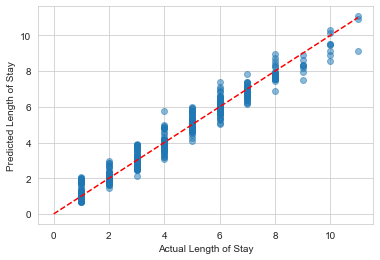

In [46]:
plt.scatter(actual_days,model.predict(X_holdout),alpha=0.5)
plt.xlabel('Actual Length of Stay')
plt.ylabel('Predicted Length of Stay')
plt.plot([i for i in range(0,12)],[i for i in range(0,12)],color = 'r',linestyle = 'dashed')

plt.show()

In [47]:
#SDoH and Operations Data
ops_df=pd.read_csv("/Users/.../sdohandoperationsdata.csv",encoding='windows-1252')
ops_df.head()

,eid,patient name,address,lat,lon,transport issues,snf issues,insurance insurance,isolation issues,cms glos,...,Transport_Servicer_Phone_Number,SNF_Servicer,SNF_Servicer_Address,SNF_Servicer_ZiPcode,SNF_Servicer_Phone_Number,Insurance_Servicer,Insurance_Servicer_Address,Insurance_Servicer_ZiPcode,Insurance_Servicer_Phone_Number,Isolation_Referral
0,29001,JosÃ© Eduardo181 GÃ³mez206,"496 Hackett Extension Apt 9, Agawam, MA 01001",42.024657,-72.691725,0,0,0,0,3.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29002,Milo271 Feil794,"963 Macejkovic Drive, Agawam, MA 01001",42.053299,-72.611905,0,0,0,0,3.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29004,Jayson808 Fadel536,"519 Stokes Hollow, Agawam, MA 01001",42.054250,-72.658801,1,0,0,0,3.9,...,800-123-1113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,29006,Mariana775 Rutherford999,"1050 Nitzsche Wall, Belchertown, MA 01007",42.281992,-72.412459,0,1,0,0,3.9,...,NaN,XYZ Skilled Nursing Facility [Bed Size ~ 200],124 Sporer Throughway,1013.0,800-123-1114,NaN,NaN,NaN,NaN,NaN
4,29008,Gregorio366 Auer97,"427 Balistreri Way Unit 19, Chicopee, MA 01013",42.228354,-72.562951,0,0,1,1,3.9,...,NaN,NaN,NaN,NaN,NaN,ABF Insurance Services,126 Sporer Throughway,1013.0,800-123-1116,ABC Isolation Services [800-123-1117]


In [48]:
#Merge Clinical and Operations Data
a="""select x.*,y.* from holdout_df x
left join ops_df y on x.eid=y.eid
;"""
pysqldf = lambda a: sqldf(a, globals())
clin_and_ops_df = pysqldf(a)

In [49]:
clin_and_ops_df.to_csv('/Users/.../Holdout_and_Ops_Data_CHF_Results.csv',index=False)